In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

-0.01084098704 0.02815552265 0.00039265133851975654
-2.7060759968018644 5.4425630702179895 -1.848446242872269e-17


Text(0.5, 1.0, 'Original matrix')

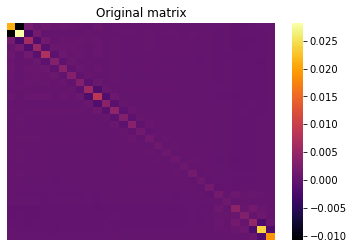

In [2]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
print(np.min(syscov), np.max(syscov), np.mean(syscov))
nsize = len(syscov)
scaler_sys = StandardScaler()
scaler_sys.fit(syscov)
syscov = scaler_sys.transform(syscov)
print(np.min(syscov), np.max(syscov), np.mean(syscov))
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(syscov)), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Original matrix')

In [3]:
def permutMatrix(omatrix, nmatrix):
    nsize = len(omatrix)
    matrixset = np.zeros((nmatrix, nsize, nsize))
    for it in range(nmatrix):
        perm = np.random.permutation(nsize)
        P = np.eye(nsize)[perm]
        p = P@omatrix@P.T
        matrixset[it, :, :] = p
    return matrixset


In [4]:
import math

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix            

### Generate a data set with covariance matrix from the original plus gaussian noise

In [5]:
magnitudes = matrixMag(syscov)

In [6]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))
permMatrix = permutMatrix(syscov, numMatrix)
print(np.shape(permMatrix))

(10000, 31, 31)


In [7]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                err = np.random.rand()
                covset[i, row, col] = permMatrix[i, row, col] + 0.0001*err*magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col] + 0.0001*err*magnitudes[row, col]
            else:
                covset[i, row, col] = permMatrix[i, row, col] + 0.1*np.random.rand()*magnitudes[row, col]
                covset_noise[i, row, col] = permMatrix[i, row, col]  + np.random.rand()*magnitudes[row, col]

 Generating 10000 matrix                

In [8]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

(10000, 31, 31)


Text(0.5, 1.0, 'NOISE MATRIX')

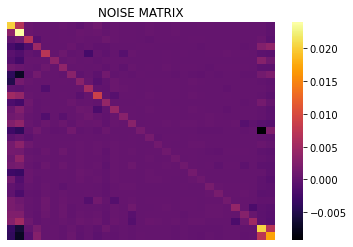

In [9]:
# sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(permMatrix[0, :, :])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("NOISE MATRIX")

Text(0.5, 1.0, 'TEST MATRIX')

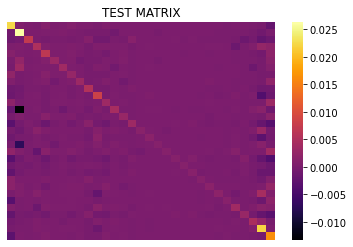

In [10]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_test[0])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title("TEST MATRIX")

In [11]:
input_img = tf.keras.Input(shape=(31, 31, 1))

x = layers.ZeroPadding2D(((5,4),(5,4)))(input_img)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(1, (5, 5), activation='linear', padding='same')(x)
decoded = layers.Cropping2D(cropping=((5, 4), (5, 4)))(x)

autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')


autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 31, 31, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 8)         1160  

In [12]:
autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=50,
                batch_size=128,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))

Epoch 1/50
63/63 [==============================] - 23s 354ms/step - loss: 0.8544 - val_loss: 0.3257
Epoch 2/50
63/63 [==============================] - 23s 369ms/step - loss: 0.2980 - val_loss: 0.2603
Epoch 3/50
63/63 [==============================] - 23s 365ms/step - loss: 0.2578 - val_loss: 0.2449
Epoch 4/50
63/63 [==============================] - 24s 386ms/step - loss: 0.2439 - val_loss: 0.2621
Epoch 5/50
63/63 [==============================] - 22s 356ms/step - loss: 0.2406 - val_loss: 0.2299
Epoch 6/50
63/63 [==============================] - 22s 353ms/step - loss: 0.2334 - val_loss: 0.2326
Epoch 7/50
63/63 [==============================] - 22s 350ms/step - loss: 0.2292 - val_loss: 0.2268
Epoch 8/50
63/63 [==============================] - 21s 336ms/step - loss: 0.2259 - val_loss: 0.2237
Epoch 9/50
63/63 [==============================] - 21s 336ms/step - loss: 0.2269 - val_loss: 0.2221
Epoch 10/50
63/63 [==============================] - 21s 336ms/step - loss: 0.2230 - val_lo

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

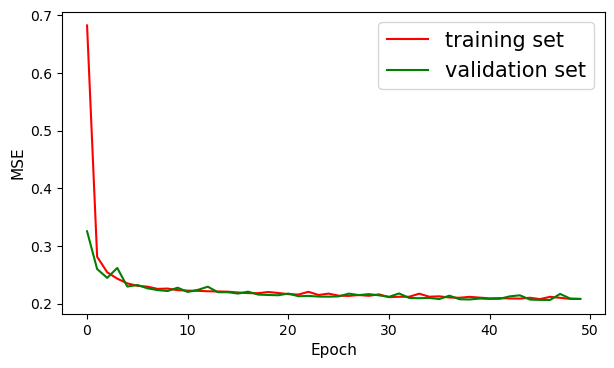

In [13]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [14]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

0.2065777778625488 0.20809942483901978


In [15]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

Text(0.5, 1.0, 'Test matrix')

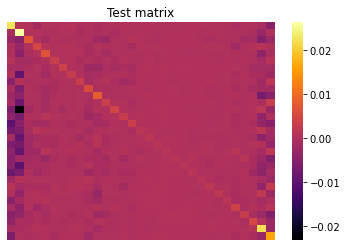

In [16]:
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(covset_noise_test[0])), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)
plt.title('Test matrix')

(2000, 31, 31)


Text(0.5, 1.0, 'Clean matrix')

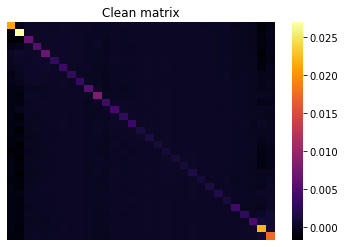

In [17]:
clean_img = autoencoder.predict(covset_noise_test)

print(np.shape(covset_noise_test))
clean_imgr = scaler_sys.inverse_transform(clean_img[0].reshape(31,31))

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Clean matrix')

Text(0.5, 1.0, 'Clean matrix 2')

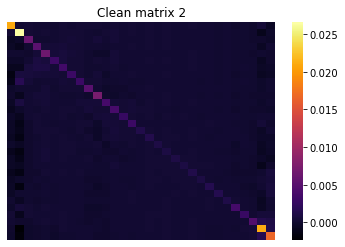

In [18]:
clean_img = autoencoder.predict(clean_img)

clean_imgr = scaler_sys.inverse_transform(clean_img[0].reshape(31,31))

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Clean matrix 2')

Text(0.5, 1.0, 'Filled matrix')

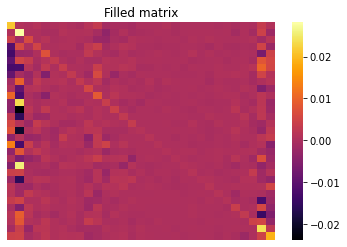

In [19]:
filled_matrix = np.zeros((nsize, nsize))
for row in range(nsize):
    for col in range(nsize):
        if row == col:
#             err = np.random.randn()
            filled_matrix[row, col] = syscov[row, col] 
#     + 0.1*err*magnitudes[row, col]
        else:
            err = np.random.randn()
            filled_matrix[row, col] = err*magnitudes[row, col]
np.shape(filled_matrix)     
sns.heatmap(pd.DataFrame(scaler_sys.inverse_transform(filled_matrix)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.title('Filled matrix')

Text(0.5, 1.0, 'Clean matrix')

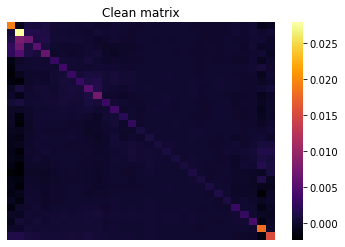

In [20]:
# filled_matrix = scaler_sys.transform(filled_matrix).reshape(1,31,31,1)

clean_img = autoencoder.predict(filled_matrix.reshape(1,31,31,1))

clean_imgr = scaler_sys.inverse_transform(clean_img[0,:,:,0])

sns.heatmap(pd.DataFrame(clean_imgr), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

plt.title('Clean matrix')

In [21]:
np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")

In [27]:
# autoencoder.save('../models/autoencoderCONV_JLA.h5')
# decoder.save('../models/decoderJLA.h5')
# encoder.save('../models/encoderJLA.h5')